In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import deque
from datetime import datetime
from decimal import Decimal
from enum import Enum
from itertools import cycle
from math import floor
import numpy as np
import pandas as pd
from random import randrange, seed
from os.path import join

from pprint import pprint

import matplotlib.pyplot as plt
from sklearn import preprocessing

from keras.models import load_model, Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam

Using TensorFlow backend.
/Users/bhsu/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:
#path = '/home/b3arjuden/crocket/sql_data/PRODUCTION40'

path = '/Users/bhsu/crypto/sql_data/PRODUCTION40'

file = 'BTC-ETH.csv'

In [2]:
file_path = join(path, file)

data = pd.read_csv(file_path, 
                   dtype={'time': str, 'buy_order': int, 'sell_order': int},
                   converters={'price': Decimal,
                               'wprice': Decimal,
                               'base_volume': Decimal,
                               'buy_volume': Decimal,
                               'sell_volume': Decimal})

NameError: name 'path' is not defined

In [15]:
def time_transform(df, n):
    
    df1 = pd.DataFrame()
    
    nrows = n * floor(df.shape[0] / n)
    df = df.iloc[:nrows, :]
    
    df1['time'] = df.loc[df.index[::n], 'time'].reset_index(drop=True)
    df1['open'] = (df.loc[::n, 'wprice'].values)
    df1['high'] = (df.loc[:, 'wprice'].groupby(df.index // n).max()) # TODO: estimate using 2 standard deviation from mean
    df1['low'] = (df.loc[:, 'wprice'].groupby(df.index // n).min()) # TODO: estimate using 2 standard deciation from mean 
    df1['close'] = (df.loc[(n-1)::n, 'wprice'].values)
    
    df1['buy_volume'] = df.loc[:, 'buy_volume'].groupby(df.index // n).sum()
    df1['sell_volume'] = df.loc[:, 'sell_volume'].groupby(df.index // n).sum()
    df1['buy_order'] = df.loc[:, 'buy_order'].groupby(df.index // n).sum()
    df1['sell_order'] = df.loc[:, 'sell_order'].groupby(df.index // n).sum()
    
    #df1['wprice'] = ((df.loc[:, 'wprice'] * df.loc[:, 'base_volume']).groupby(df.index // n).sum() / 
    #                 df.loc[:, 'base_volume'].groupby(df.index // n).sum()).apply(lambda x: float(x.quantize(Decimal(10) ** -8)))
    
    return df1

def vectorize(array):
    
    return np.expand_dims(np.expand_dims(array, axis=0), axis=0)

In [2]:
class NeuralNetwork:
    
    def __init__(self, 
                 num_actions,
                 checkpoint_path=None):
        
        self.checkpoint_path = checkpoint_path
        
        self.count_states = 0
        self.count_episodes = 0
    
    def build(self):
        
        model = Sequential()
        model.add(LSTM(18, batch_input_shape=(1, 1, 2), activation='tanh', stateful=True))
        
        model.add(Dense(3, activation='softmax'))
        
        # Optimizer: adam, RMSProp
        model.compile(optimizer='adam', loss='mse')
        
        self.model = model
    
    def save(self):
        
        save_file = 'network_S{}_E{}.h5'.format(self.count_states, self.count_episodes)
        model.save(join(self.checkpoint_path, save_file))
    
    def load(self, model_path):
        
        self.model = load_model(model_path)
        
        # TODO: load count_states and count_episodes from file
    
    def get_weights(self):
        
        return [layer.get_weights() for layer in self.model.layers]
    
    def set_weights(self, weights):
        
        for layer, new_weights in zip(self.model.layers, weights):
            layer.set_weights(new_weights)
    
    def interpolate_weights(self, weights, interpolation_factor=0.001):
        
        for layer, new_weights in zip(self.model.layers, weights):
            layer.set_weights([w1 * interpolation_factor + (1 - interpolation_factor) * w0 for w0, w1 in zip(layer.get_weights(), new_weights)])
    
    # TODO: add initialization function?

In [3]:
class Agent:
    """
    Rules:
    - Position = 0 -> HOLD, BUY
    - Position => 1 -> HOLD, SELL
    """
    
    def __init__(self, parameters):
        
        self.num_actions = parameters.num_actions
        self.discount_factor = parameters.discount_factor
        self.epsilon = parameters.epsilon
        self.epsilon_min = parameters.epsilon_min
        self.epsilon_decay = parameters.epsilon_decay
        self.priority_alpha = parameters.priority_alpha
        self.batch_size = parameters.batch_size
        
        self.prioritized_memory = parameters.prioritized_memory
        self.replay_capacity = parameters.replay_capacity
        self.state_length = parameters.state_length
        self.priority_epsilon = parameters.priority_epsilon
        
        self._initialize()
        
    def _initialize(self, model_path=None):
        
        self.train_network = NeuralNetwork(num_actions=self.num_actions)
        self.target_network = NeuralNetwork(num_actions=self.num_actions)
        
        if model_path:
            pass
            # TODO: implement load model from folder (network_weights, replay_memory, additional_params)
        else:
            
            if self.prioritized_memory:
                self.replay_memory = PrioritizedReplayMemory(capacity=self.replay_capacity)
            else:
                self.replay_memory = ReplayMemory(capacity=self.replay_capacity,
                                                  state_shape=self.state_length,
                                                  num_actions=self.num_actions)

            self.train_network.build()
            self.target_network.build()
            
            self.target_network.set_weights(self.train_network.get_weights())
        
    def act(self, state):
        
        # no position -> actions allowed: HOLD, BUY
        # active position -> HOLD, BUY, SELL
        
        buy_price = state[-1]
        
        if buy_price == 0:
            actions = [0, 1]
        else:
            actions = [0, 2]
            
        if np.random.rand() < self.epsilon:
            return actions[np.random.randint(2)]
        
        values = self.train_network.model.predict(vectorize(state))
        
        return actions[np.argmax(values[0][actions])]
    
    def replay(self):
        """
        Replay options: 1) replay memory, 2) prioritized replay memory
        """
        if self.prioritized_memory:
            idx, priorities, experience = self.replay_memory.sample(self.batch_size)
            
            # Update transition priorities
        else:
            episodes = self.replay_memory.random_batch(self.batch_size)
            
            for e in episodes:
                
                states_batch = np.array(e.states)
                action_batch = np.array(e.actions)
                rewards_batch = np.array(e.rewards)
                next_states_batch = np.array(e.next_states)
                
                for state, action, reward, next_state in (states_batch, action_batch, rewards_batch, next_states_batch):
                    
                    q_values_next = self.train_network.model.predict(next_states_batch)
                    best_actions = np.argmax(q_values_next, axis=1)
                    q_values_next_target = self.target_network.model.predict(next_states_batch)

                    # SELL equivalent to end of episode
                    targets_batch = reward_batch + \
                        (action_batch != 2).astype(int) * (self.discount_factor * np.repeat(q_values_next_target[np.arange(self.batch_size), best_actions].reshape(self.batch_size, 1), self.num_actions, axis=1))

                    targets_batch = targets_batch * np.stack([[1, 1, 0] if x[-1, -1] == 0 else [1, 0, 1] for x in states_batch])

                    # TODO: consider clip reward
                    # Update train model
                    self.train_network.model.fit(states_batch, targets_batch)
                
                self.train_network.reset_states()

            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
    
    def initialize_replay_memory(self, env, parameters, price_index):
        
        print('Initializing replay memory...')
        
        for e in range(parameters.replay_capacity):
            
            episode = Episode()
            state = env.reset()
            
            for idx in range(env.steps):
                
                action = self.act(state)
                next_state, reward, _ = env.step(action, price_index)

                if self.prioritized_memory:
                    # TODO: refactor
                    self.replay_memory.add((state, action, reward, next_state), max(self.priority_max, self.priority_epsilon))
                else:
                    episode.add(state, action, reward, next_state)

                state = next_state

            state = env.reset()
            self.replay_memory.add(episode)
            
        print('Replay memory initialized.')
        
    def update_transition_priorities(self, states_batch, actions_batch, rewards_batch, targets_batch, indexes):
        
        for s0, a, r, t, i in zip(states_batch, actions_batch, rewards_batch, targets_batch, indexes):
            
            priority = (abs(self.train_network.model.predict(s0)[a] - t[a]) + self.priority_epsilon) ** self.priority_alpha

In [38]:
class Episode:
    
    def __init__(self):
        
        # TODO: improve performance
        self.states = []
        self.actions = []
        self.rewards = []
        self.states_next = []
        
    def add(self, state, action, reward, next_state):
        
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
        self.states_next.append(next_state)

In [4]:
class ReplayMemory:
    
    # TODO: use collections.deque
    # Store list of episodes
        
    def __init__(self, capacity, state_shape, num_actions):
        
        self.capacity = capacity
        self.episodes = []
        
        self.indexes = cycle(range(capacity))
        self.pointer = next(self.indexes)
        
    def add(self, episode):
        
        k = self.pointer

        self.episodes[k] = episode
        
        self.pointer = next(self.indexes)
        
    def random_batch(self, batch_size):
        
        idx = np.random.randint(self.capacity, size=batch_size)
        
        return self.episodes[idx]
    
    def random_batch_priority(self, batch_size, non_hold_ratio):
        """
        Sample from hold entries and buy/sell entires separately
        """
        
        num_non_hold = int(batch_size * non_hold_ratio)
        num_hold = batch_size - num_non_hold
        
        non_hold_idx = set(i for i, x in enumerate(self.actions) if x[0] != 0)
        hold_idx = set(range(self.capacity)) - non_hold_idx
        
        idx = np.concatenate((np.random.choice(list(hold_idx), size=num_hold), np.random.choice(list(non_hold_idx), size=num_non_hold)))
        
        return self.states[idx], self.actions[idx], self.rewards[idx], self.states_next[idx], idx 

In [5]:
class PrioritizedReplayMemory:
    """
    SumTree.
    Data: (state, action, reward, next_state)
    """
    
    def __init__(self, capacity):
        
        self.capacity = capacity
        self.tree = np.zeros(2*capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        
        self.pointer = 0
    
    def _propagate(self, idx, change):
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        left = 2 * idx + 1

        if left >= self.tree_len:
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            right = left + 1
            return self._retrieve(right, s-self.tree[left])

    def total(self):
        return self.tree[0]

    def add(self, data, p):
        idx = self.pointer + self.capacity - 1

        self.data[self.pointer] = data
        self.update(idx, p)

        self.pointer += 1
        
        if self.pointer >= self.capacity:
            self.pointer = 0

    def update(self, idx, p):
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        idx = self._retrieve(0, s)
        data_idx = idx - self.capacity + 1

        return idx, self.tree[idx], self.data[data_idx]

    def sample(self, batch_size):
        batch_idx = [None] * batch_size
        batch_priorities = [None] * batch_size
        batch = [None] * batch_size
        segment = self.total() / batch_size

        a = [segment*i for i in range(batch_size)]
        b = [segment * (i+1) for i in range(batch_size)]
        s = np.random.uniform(a, b)

        for i in range(batch_size):
            (batch_idx[i], batch_priorities[i], batch[i]) = self.get(s[i])

        return batch_idx, batch_priorities, batch

In [6]:
class Environment:
    
    def __init__(self,
                 input_data,
                 steps=None):
        
        self.steps = steps
        self._load(input_data)
        
        self.episode = {}
        
    def _load(self, input_data):
        
        self.data = input_data
        
        self.shape = input_data.shape
        
        if self.steps is None or self.steps > self.shape[0]:
            self.steps = self.shape[0] - 1
    
    def _seed(self):
        
        seed()
        
    def reset(self):
        
        self._seed()
        self.episode['start'] = np.random.randint(0, self.shape[0] - self.steps)
        self.episode['current_index'] = self.episode.get('start')
        self.data[:, -1] = 0  # Reset buy state
        
        return self.data[self.episode.get('current_index')]
        
    def step(self, action, price_index):
        
        current_index = self.episode.get('current_index')
        state = self.data[current_index]
        next_state = self.data[current_index + 1]

        price = state[0]
        buy_price = state[-1]
        
        if action == 1:
            next_state[-1] = price
            reward = [0, price * -1, 0]
        elif action == 2:
            next_state[-1] = 0
            reward = [0, 0, price - buy_price]
        else:
            # TODO: set reward to difference between buy_price and current_price if position held, but smaller magnitude than buying or selling
            next_state[-1] = buy_price
            reward = [0, 0, 0]
        
        self.episode['current_index'] += 1
        
        return next_state, reward, current_index 

In [7]:
class Action(Enum):

    HOLD = 0
    BUY = 1
    SELL = 2

In [8]:
class Summary:
    
    def __init__(self, parameters=None):
        
        self.episodes = []
        self.params = parameters
        
    def create(self, actions, train_reward, actual_reward, start, end, epsilon_end):
        
        # TODO: add epsilon values
        
        self.episodes.append({
            'actions': actions,
            'train_reward': train_reward,
            'actual_reward': actual_reward,
            'start': start,
            'end': end,
            'epsilon_end': epsilon_end
        })
        
    def summarize_all(self):
        
        num_episodes = len(self.episodes)
        train_reward = np.zeros(num_episodes)
        actual_reward = np.zeros(num_episodes)
        epsilon_end = np.zeros(num_episodes)
        
        for ii in range(num_episodes):
            train_reward[ii], actual_reward[ii], epsilon_end[ii] = (self.episodes[ii][x] for x in ['train_reward', 'actual_reward', 'epsilon_end'])
        
        # TODO: add plot here
        
        return train_reward, actual_reward, epsilon_end
    
    def summarize_episode(self, episode_num):
        
        episode_summary = self.episodes[episode_num]
        
        return episode_summary
    
    def get_price(self, price, episode_num):
        
        start = self.episodes[episode_num].get('start')
        end = self.episodes[episode_num].get('end')
        
        return price[start:end]

In [17]:
# Data processing parameters
n = 15
m = 8

In [18]:
# Test data
x = np.linspace(-np.pi, np.pi, 100)
array = np.sin(x)

price_state_index = -1

min_max_scaler = preprocessing.MinMaxScaler()
normalized_array = min_max_scaler.fit_transform(array.reshape(-1, 1))

# Build states
#states = np.array([normalized_array[x:x+m, :] for x in range(normalized_array.shape[0] - m + 1)])
states = normalized_array

# Add state for position held
states = np.insert(states, states.shape[1], 0, axis=1)

# Build prices
prices = list(map(float, array[(m-1):]))

In [ ]:
# Combine data
df = time_transform(data.iloc[:200*15,:], n)
array = df.iloc[:,1:].as_matrix()

# Get close price column index
price_df_index = df.columns.get_loc('close')
price_array_index = price_df_index-1
price_state_index = m*(price_array_index+1)-1

In [ ]:
# Normalize data 
# TODO: change normalization if necessary
min_max_scaler = preprocessing.MinMaxScaler()
normalized_array = min_max_scaler.fit_transform(array)

In [ ]:
# Build states
states = np.array([normalized_array[x:x+m, :] for x in range(normalized_array.shape[0] - m + 1)])

# Add state for position
states = np.insert(states, states.shape[2], 0, axis=2)

# Build prices
prices = list(map(float, array[(m-1):, price_array_index]))

In [90]:
class Parameters:
    
    def __init__(self):
        
        # Time series parameters
        self.num_actions = 3
        
        # Neural network parameters
        self.discount_factor = 0.97
        self.epsilon = 0.99
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.98
        
        # Replay memory parameters
        self.replay_capacity = 10000
        self.batch_size = 100
        self.priority_epsilon = 1e-6
        self.priority_alpha = 2
        self.prioritized_memory = False
        
        # Training parameters
        self.episodes = 1
        self.episode_length = 92
        self.update_target_weights_step_size = 200
        self.train_network_step_size = 100
        self.interpolation_factor = 0.03

In [91]:
## Model training

parameters = Parameters()
parameters.state_length = list(states[0].shape)
agent = Agent(parameters)
env = Environment(states, steps=parameters.episode_length)
summary = Summary()
step = 0

# Populate the replay memory with initial experiences
agent.initialize_replay_memory(env, parameters, price_index=price_state_index)

for e in range(parameters.episodes):
    
    state = env.reset()
    
    episode_learn_reward = 0
    episode_actions = np.zeros(parameters.episode_length)
    episode_actual_reward = 0
    
    for ii in range(parameters.episode_length):
        
        # Update the target network weights every X iterations
        if step % parameters.update_target_weights_step_size == 0:
            print('Step {}: Updating target Q network weights with latest Q network weights.'.format(step))
            agent.target_network.interpolate_weights(agent.train_network.get_weights(), parameters.interpolation_factor)
                
        action = agent.act(state)
        next_state, reward, index = env.step(action, price_index=price_state_index)
        agent.replay_memory.add(state, action, reward, next_state)
        state = next_state
        
        episode_actions[ii] = action
        episode_learn_reward += reward[action]
        
        if action > 0:
            price = prices[index]
            episode_actual_reward += price * -1.0025 if action == 1 else price * 0.9975
        
        if step % parameters.train_network_step_size == 0:
            print('Step {}: Sampling replay memory and training Q network.'.format(step))
            
            agent.replay()
            
        step += 1

    agent
    
    summary.create(episode_actions, episode_learn_reward, episode_actual_reward, env.episode.get('start'), env.episode.get('current_index')+1, agent.epsilon)

Initializing replay memory...
Replay memory initialized.
Step 0: Updating target Q network weights with latest Q network weights.
Step 0: Sampling replay memory and training Q network.


ValueError: Error when checking : expected lstm_22_input to have 3 dimensions, but got array with shape (100, 2)

In [92]:
agent.train_network.model

In [42]:
np.expand_dims(np.expand_dims(states[0, :], axis=0), axis=0)

array([[[ 0.5,  0. ]]])

Training reward: -2.9763699772305374
Actual reward: -0.6417023712198706


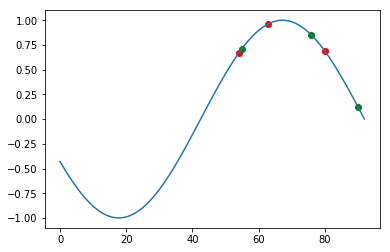

In [38]:
# Examine episode

episode_num = 997

episode_summary = summary.summarize_episode(episode_num)
episode_price = summary.get_price(prices, episode_num)
actions = episode_summary.get('actions')

print('Training reward: {}'.format(episode_summary.get('train_reward')))
print('Actual reward: {}'.format(episode_summary.get('actual_reward')))

# Plot graph of buy/sell actions
buy_indices = [x for x in range(len(actions)) if actions[x] == 1]
buy_prices = [episode_price[x] for x in buy_indices]

sell_indices = [x for x in range(len(actions)) if actions[x] == 2]
sell_prices = [episode_price[x] for x in sell_indices]

plt.plot(episode_price)
plt.scatter(buy_indices, buy_prices, color='r')
plt.scatter(sell_indices, sell_prices, color='g')

In [23]:
agent.replay_memory.rewards

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [24]:
train, actual, epsilon = summary.summarize_all()

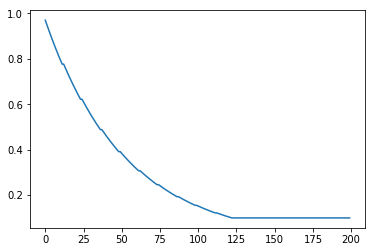

In [25]:
plt.plot(epsilon)

In [3]:
N_train = 1000
from numpy.random import choice
one_indexes = choice(a=N_train, size=int(N_train / 2), replace=False)
X_train[one_indexes, 0] = 1  # very long term memory.

NameError: name 'X_train' is not defined

In [80]:
# Neural network playground

# RNN - calls to predict store state history

model = Sequential()
model.add(LSTM(2, batch_input_shape=(1, 1, 2), activation='tanh', stateful=True))

model.add(Dense(3, activation='softmax'))

# Optimizer: adam, RMSProp
model.compile(optimizer='adam', loss='mse')

In [81]:
model.save('test_model.h5')

In [82]:
test_model = load_model('test_model.h5')

In [83]:
model.get_weights()

[array([[-0.73093283, -0.3637661 , -0.50931585,  0.47428238,  0.46101344,
         -0.53180337,  0.64970565, -0.63791853],
        [ 0.01188666, -0.04821819, -0.1984486 , -0.55533558, -0.45577481,
         -0.30892774, -0.40100241, -0.5112372 ]], dtype=float32),
 array([[ 0.31900868,  0.09988321,  0.13011806, -0.00228098,  0.76533043,
          0.00229885, -0.16670036, -0.50773609],
        [-0.14532249,  0.53168344,  0.13678308,  0.27481109, -0.29851779,
         -0.3401365 , -0.59445935, -0.20922652]], dtype=float32),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.], dtype=float32),
 array([[ 0.55039096, -0.9745031 , -0.80169487],
        [ 0.36104786, -0.00757515,  0.5540576 ]], dtype=float32),
 array([ 0.,  0.,  0.], dtype=float32)]

In [84]:
test_model.get_weights()

[array([[-0.73093283, -0.3637661 , -0.50931585,  0.47428238,  0.46101344,
         -0.53180337,  0.64970565, -0.63791853],
        [ 0.01188666, -0.04821819, -0.1984486 , -0.55533558, -0.45577481,
         -0.30892774, -0.40100241, -0.5112372 ]], dtype=float32),
 array([[ 0.31900868,  0.09988321,  0.13011806, -0.00228098,  0.76533043,
          0.00229885, -0.16670036, -0.50773609],
        [-0.14532249,  0.53168344,  0.13678308,  0.27481109, -0.29851779,
         -0.3401365 , -0.59445935, -0.20922652]], dtype=float32),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.], dtype=float32),
 array([[ 0.55039096, -0.9745031 , -0.80169487],
        [ 0.36104786, -0.00757515,  0.5540576 ]], dtype=float32),
 array([ 0.,  0.,  0.], dtype=float32)]

In [75]:
model.predict(vectorize(states[0]))

array([[ 0.33997616,  0.33627522,  0.32374865]], dtype=float32)

In [85]:
model.fit(vectorize(states[0]), np.expand_dims(np.array([1, 1, 1]), axis=0), batch_size=1, shuffle=False)

Epoch 1/1
1/1 [==============================] - 1s 1s/step - loss: 0.4446


In [86]:
test_model.fit(vectorize(states[0]), np.expand_dims(np.array([1, 1, 1]), axis=0), batch_size=1, shuffle=False)

Epoch 1/1
1/1 [==============================] - 1s 896ms/step - loss: 0.4446


In [87]:
model.get_weights()

[array([[-0.73192817, -0.36442012, -0.51030493,  0.47381532,  0.46001396,
         -0.53086317,  0.6487118 , -0.63858837],
        [ 0.01188666, -0.04821819, -0.1984486 , -0.55533558, -0.45577481,
         -0.30892774, -0.40100241, -0.5112372 ]], dtype=float32),
 array([[ 0.31805012,  0.09971247,  0.12921   , -0.00236812,  0.76433527,
          0.00293026, -0.16764657, -0.50791705],
        [-0.14436556,  0.53184849,  0.13768768,  0.27489504, -0.29752281,
         -0.34075838, -0.59351528, -0.2090515 ]], dtype=float32),
 array([ -9.97651601e-04,  -7.90818245e-04,   9.99005497e-01,
          9.99363303e-01,  -9.99736832e-04,   9.69187764e-04,
         -9.96913644e-04,  -8.02258786e-04], dtype=float32),
 array([[ 0.54939252, -0.97350794, -0.80069715],
        [ 0.36204627, -0.00857013,  0.55305994]], dtype=float32),
 array([-0.00099992,  0.00099974,  0.00099988], dtype=float32)]

In [88]:
test_model.get_weights()

[array([[-0.73192817, -0.36442012, -0.51030493,  0.47381532,  0.46001396,
         -0.53086317,  0.6487118 , -0.63858837],
        [ 0.01188666, -0.04821819, -0.1984486 , -0.55533558, -0.45577481,
         -0.30892774, -0.40100241, -0.5112372 ]], dtype=float32),
 array([[ 0.31805012,  0.09971247,  0.12921   , -0.00236812,  0.76433527,
          0.00293026, -0.16764657, -0.50791705],
        [-0.14436556,  0.53184849,  0.13768768,  0.27489504, -0.29752281,
         -0.34075838, -0.59351528, -0.2090515 ]], dtype=float32),
 array([ -9.97651601e-04,  -7.90818245e-04,   9.99005497e-01,
          9.99363303e-01,  -9.99736832e-04,   9.69187764e-04,
         -9.96913644e-04,  -8.02258786e-04], dtype=float32),
 array([[ 0.54939252, -0.97350794, -0.80069715],
        [ 0.36204627, -0.00857013,  0.55305994]], dtype=float32),
 array([-0.00099992,  0.00099974,  0.00099988], dtype=float32)]

In [150]:
model.get_weights()

[array([[ 0.13670987, -0.25626671,  0.35413641,  0.05407447, -0.23540521,
         -0.00872707, -0.23882103, -0.21924084],
        [ 0.14995754, -0.37987173,  0.73043746,  0.51833218, -0.41518304,
         -0.30856588,  0.32293063,  0.43715757],
        [-0.14346653, -0.58722466,  0.09635061, -0.42959249, -0.12475342,
          0.48008007,  0.20320719,  0.52007014]], dtype=float32),
 array([[ -1.19848497e-01,  -1.05012525e-02,  -2.84707963e-01,
           4.05847937e-01,  -5.25312759e-02,   3.98373187e-01,
          -4.87123698e-01,  -5.83956063e-01],
        [  3.55554948e-04,   6.20316327e-01,  -3.83881956e-01,
          -1.94700994e-02,  -1.86089277e-01,   1.41730011e-01,
          -3.30079406e-01,   5.51175177e-01]], dtype=float32),
 array([ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.], dtype=float32),
 array([[ 0.35717392],
        [-1.1435802 ]], dtype=float32),
 array([ 0.], dtype=float32)]

In [151]:
test_model.get_weights()

[array([[-0.14307576,  0.53988099, -0.08345276,  0.15672588,  0.24964613,
          0.12790012, -0.07451165, -0.20258969, -0.34309155,  0.31779039,
          0.60426831, -0.50093889],
        [ 0.5596348 ,  0.26232028,  0.15591896,  0.11767244, -0.25093207,
         -0.03600758, -0.03117216,  0.58335876,  0.25778687,  0.56229258,
          0.3730216 , -0.4971121 ]], dtype=float32),
 array([[ 0.17935   ,  0.10540307,  0.39597896,  0.24963087, -0.27444357,
         -0.5804953 , -0.36762106,  0.07931638, -0.12631567, -0.3159796 ,
          0.26089209, -0.00387509],
        [ 0.19038658, -0.21856263,  0.11403145,  0.13949299,  0.04758941,
         -0.23152837,  0.49736854, -0.26391017, -0.24368083, -0.2290431 ,
         -0.42155778,  0.4701868 ],
        [ 0.18658625,  0.34733692, -0.11857619,  0.00143213, -0.5228526 ,
         -0.09826455,  0.40348285,  0.39495933,  0.40627801, -0.01568197,
         -0.23384646, -0.09309311]], dtype=float32),
 array([ 0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.

In [161]:
test_model.predict(vectorize(states[0]))

array([[ 0.33073106,  0.33260202,  0.33666694]], dtype=float32)

In [162]:
test_model.reset_states()

In [163]:
test_model.predict(vectorize(states[0]))

array([[ 0.33073106,  0.33260202,  0.33666694]], dtype=float32)

In [154]:
test_model.get_weights()

[array([[-0.14307576,  0.53988099, -0.08345276,  0.15672588,  0.24964613,
          0.12790012, -0.07451165, -0.20258969, -0.34309155,  0.31779039,
          0.60426831, -0.50093889],
        [ 0.5596348 ,  0.26232028,  0.15591896,  0.11767244, -0.25093207,
         -0.03600758, -0.03117216,  0.58335876,  0.25778687,  0.56229258,
          0.3730216 , -0.4971121 ]], dtype=float32),
 array([[ 0.17935   ,  0.10540307,  0.39597896,  0.24963087, -0.27444357,
         -0.5804953 , -0.36762106,  0.07931638, -0.12631567, -0.3159796 ,
          0.26089209, -0.00387509],
        [ 0.19038658, -0.21856263,  0.11403145,  0.13949299,  0.04758941,
         -0.23152837,  0.49736854, -0.26391017, -0.24368083, -0.2290431 ,
         -0.42155778,  0.4701868 ],
        [ 0.18658625,  0.34733692, -0.11857619,  0.00143213, -0.5228526 ,
         -0.09826455,  0.40348285,  0.39495933,  0.40627801, -0.01568197,
         -0.23384646, -0.09309311]], dtype=float32),
 array([ 0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.